In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('wrds_out.csv.gz')
df[:3]

,PERMNO,date,TICKER,PERMCO,PRC,RET,SHROUT
0,10026,2019-01-31,JJSF,7976,154.35001,0.067501,18783.0
1,10026,2019-02-28,JJSF,7976,155.28000,0.006025,18783.0
2,10026,2019-03-29,JJSF,7976,158.84000,0.026146,18815.0


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df[:3]

,PERMNO,TICKER,PERMCO,PRC,RET,SHROUT
date,,,,,,
2019-01-31,10026,JJSF,7976,154.35001,0.067501,18783.0
2019-02-28,10026,JJSF,7976,155.28000,0.006025,18783.0
2019-03-29,10026,JJSF,7976,158.84000,0.026146,18815.0


In [5]:
df.sort_index(inplace=True)
df[:3]

,PERMNO,TICKER,PERMCO,PRC,RET,SHROUT
date,,,,,,
2019-01-31,10026,JJSF,7976,154.35001,0.067501,18783.0
2019-01-31,14187,DBEU,53807,26.72000,0.061581,30250.0
2019-01-31,90762,LOR,46885,9.56000,0.128872,6880.0


In [6]:
def cheapo_float(s):
    try:
        return float(s)
    except:
        return np.nan
df['RET'] = df['RET'].map(cheapo_float)

In [7]:
df = df.dropna(how='any')
df.dtypes

PERMNO      int64
TICKER     object
PERMCO      int64
PRC       float64
RET       float64
SHROUT    float64
dtype: object

In [8]:
df['logret'] = np.log(1+df['RET'])

In [9]:
def do_one_step(df, start=0, window=6, bins=20):
    all_months = list(sorted(df.index.unique()))
    if start<0 or start+window+1>=len(all_months):
        return None
    
    df_train = df.loc[all_months[start:start+window]]
    df_test = df.loc[all_months[start+window+1]]
    
    z = df_train.groupby(['PERMNO', 'TICKER'])['logret'].sum().reset_index().sort_values(by='logret', ascending=False)
    z['logret_bin'] = pd.qcut(z['logret'], bins)
    df_train_joined = df_train.reset_index().merge(z[['PERMNO', 'logret_bin']], left_on='PERMNO', right_on='PERMNO')
    long_or_short_sign = 2*(df_train_joined.groupby('logret_bin')['RET'].mean() > 0).astype(int)-1
    train_returns = df_train_joined.groupby('logret_bin')['RET'].mean() * long_or_short_sign
    
    df_test_joined = df_test.reset_index().merge(z[['PERMNO', 'logret_bin']], left_on='PERMNO', right_on='PERMNO')
    
    test_returns = df_test_joined.groupby('logret_bin')['RET'].mean() * long_or_short_sign
    return train_returns, test_returns

In [10]:
train_returns, test_returns = [], []
window, bins = 6, 30
for i in range(50):
    res = do_one_step(df, i, window=window, bins=bins)
    if res is not None:
        train_returns.append(res[0])
        test_returns.append(res[1])

In [11]:
train_returns = np.vstack(train_returns) # timesteps * #bins
test_returns = np.vstack(test_returns)

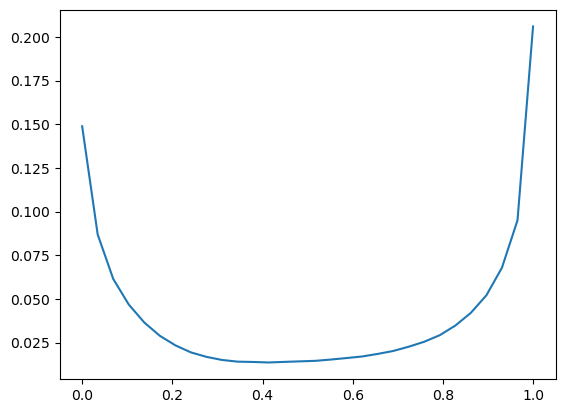

In [12]:
#plt.errorbar(np.arange(20), np.mean(train_returns, axis=0), yerr=np.std(train_returns, axis=0))
plt.plot(np.linspace(0, 1, train_returns.shape[1]), np.mean(train_returns, axis=0))

In [13]:
Sigma = np.cov(train_returns.T)
B = Sigma[[-1,0]][:,[-1,0]]
B

array([[ 0.00746678, -0.00342541],
       [-0.00342541,  0.00200765]])

In [14]:
thisD = np.diag(np.sqrt(1/np.diagonal(B)))
thisD @ B @ thisD

array([[ 1.        , -0.88471407],
       [-0.88471407,  1.        ]])

In [15]:
from scipy.interpolate import CubicSpline, BSpline
import cvxpy as cp

y = np.mean(train_returns, axis=0)
x = np.linspace(0,1,len(y))
all_x = np.linspace(0,1,100)

k, num_c = 4, 30
t = np.linspace(0, 1, num_c)
b_spline = BSpline(t, np.eye(num_c), k)

coeffs = cp.Variable(num_c)
objective = cp.sum_squares(b_spline(x) @ coeffs - y)
constraints = [b_spline(all_x, 2) @ coeffs >= 0]
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()
spl = BSpline(t, coeffs.value, k)

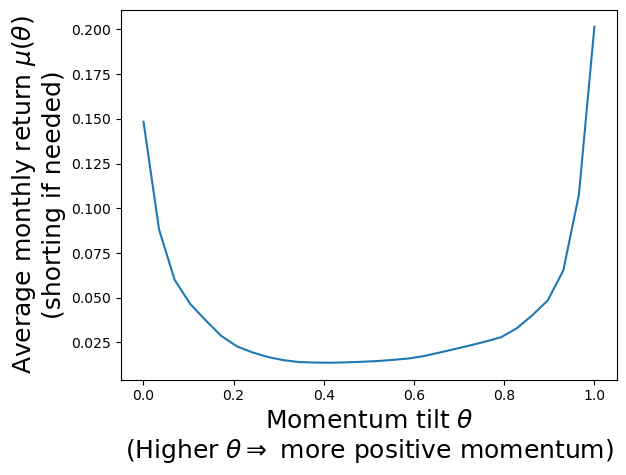

In [16]:
fontsize = 18
#plt.plot(x, y, label='Actual')
plt.plot(x, spl(x), label='Spline')
plt.xlabel(r'Momentum tilt $\theta$' +'\n' + r'(Higher $\theta\Rightarrow$ more positive momentum)', fontsize=fontsize)
plt.ylabel(r'Average monthly return $\mu(\theta)$' + '\n' + r'(shorting if needed)', fontsize=fontsize)
#plt.legend()
fig = plt.gcf()
#fig.savefig('figs/wrds_mom_mu.png', bbox_inches='tight')

In [17]:
from scipy.linalg import solve_sylvester

def get_T(t):
    return np.vstack([t, 1-t]).T

def get_t(tval, n=10, m=5):
    t = np.zeros(n)
    t[:m] = 1
    t[m] = tval
    return t

def get_M(mu):
    ones = np.ones(len(mu))
    M = np.outer(mu, ones)
    return M

def get_W(M, Sigma):
    W = solve_sylvester(Sigma, Sigma, 0.5*(M+M.T))
    return W
def get_W_from_T(T, rho, **kwds):
    mu = get_mu(T, **kwds)
    M = get_M(mu)
    Sigma = get_Sigma(T, rho=rho)
    W = get_W(M, Sigma)
    return W
def get_utilities(T, rho, **kwds):
    W = get_W_from_T(T, rho, **kwds)
    Sigma = get_Sigma(T, rho=rho)
    utilities = np.diag(W @ Sigma @ W)
    return utilities

In [18]:
def get_our_utils(n, f, train_returns, B=None, spline=None):
    m = int(n*f)

    y = np.mean(train_returns, axis=0)
    
    our_mu = np.zeros(n)
    if spline is None:
        our_mu[:m] = y[-1]
        our_mu[m+1:] = y[0]
    else:
        our_mu[:m] = spline(1)
        our_mu[m+1:] = spline(0)

    our_Sigma = np.zeros((n, n))
    our_Sigma[:m, :m] = Sigma[-1,-1]
    our_Sigma[:m, m+1:] = Sigma[0, -1]
    our_Sigma[m+1:, :m] = Sigma[0, -1]
    our_Sigma[m+1:, m+1:] = Sigma[0, 0]
    our_Sigma += 0.1 * np.identity(n)
    # our_Sigma += 1e-2 * np.identity(n)

    utils = {}
    t_idx_arr = range(len(y)) if B is None or spline is None else np.linspace(0,100,100)
    for t_idx in t_idx_arr:
    #for t_idx in [15]:
        this_mu = our_mu.copy()
        if spline is None:
            this_mu[m] = y[t_idx]
        else:
            this_mu[m] = spline(t_idx / (len(t_idx_arr)-1))
        this_M = get_M(this_mu)

        this_Sigma = our_Sigma.copy()
        if B is None:
            this_Sigma[m, :m] = Sigma[-1, t_idx]
            this_Sigma[m, m] = Sigma[t_idx, t_idx]
            this_Sigma[m, m+1:] = Sigma[t_idx, 0]
            this_Sigma[:m, m] = this_Sigma[m,:m]
            this_Sigma[m+1:, m] = this_Sigma[m, m+1:]
        else:
#             t = np.zeros(n)
#             t[:m] = 1
#             t[m] = t_idx/(len(y)-1)
            this_T = get_T(get_t(tval=t_idx/(len(t_idx_arr)-1), n=n, m=m))
            this_Sigma = this_T @ B @ this_T.T + 0.1 * min(np.diagonal(B)) * np.identity(n)
            # print(this_Sigma[[0,m,-1]][:,[0,m,-1]])
            
    #     print(this_Sigma)

    #     tmp = (train_returns.shape[1]-1) * np.ones(n, dtype=int)
    #     tmp[m] = t_idx
    #     tmp[m+1:] = 0
    #     this_Sigma = np.cov(train_returns[:,tmp].T).reshape(n,n) #+ 1e-2 * np.identity(n)
    #     print(this_Sigma)
    #     print()

    #     print(this_Sigma, Sigma[t_idx, t_idx])

        W = get_W(this_M, this_Sigma)
        # print(W[[0,m,-1]][:,[0,m,-1]])
        utilities = np.diag(W.T @ (this_Sigma @ W))
        utils[t_idx/(len(t_idx_arr)-1)] = utilities[m]
    #     print(np.linalg.norm(W-W.T)/np.linalg.norm(W), utilities[m], W[m] @ (this_Sigma @ W[m]))

    return utils

    # Series(pred_utils).plot()
    #Series(y, index=np.arange(len(y))/len(y)).plot()

In [19]:
def util_one_firm(tval, mu_m, B):
    vec_t = np.array([tval, 1-tval]).T
    s = np.diagonal(vec_t @ B @ vec_t.T) + 0.1 * min(np.diagonal(B))
    # s = np.square(tval) + np.square(1-tval) + 2*rho*tval*(1-tval)
    return 1/4*np.square(mu_m)/s

In [20]:
fontsize, legend_fontsize = 18, 14
markers = ['s', 'o', 'v']
colors = ['blue', 'red', 'black']

Text(0, 0.5, 'Utility')

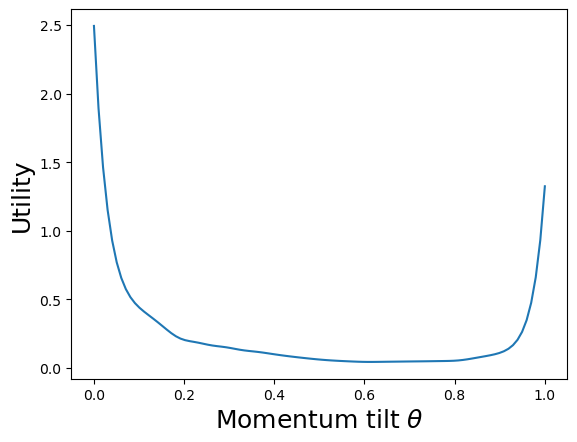

In [21]:
all_t = np.linspace(0,1,100)
one_firm_utils = util_one_firm(tval=all_t, mu_m=spl(all_t), B=B)
plt.plot(all_t, one_firm_utils)
plt.xlabel(r"Momentum tilt $\theta$", fontsize=fontsize)
plt.ylabel(r"Utility", fontsize=fontsize)
# fig = plt.gcf()
# fig.savefig('figs/wrds_mom_one_firm.png', bbox_inches='tight')

In [22]:
n = 401
all_utils = {}
for f in [0.3, 0.5, 0.7]:
    utils = get_our_utils(n=n, f=f, train_returns=train_returns, B=B, spline=spl)
    all_utils[f] = utils

[None]

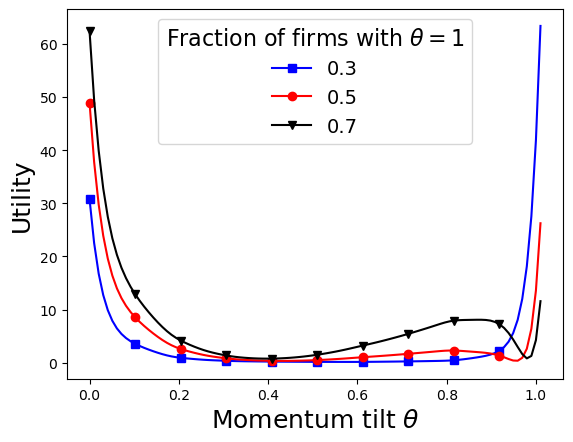

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for idx, f in enumerate(all_utils.keys()):
    Series(all_utils[f]).plot(ax=ax, marker=markers[idx], color=colors[idx], markevery=10, label=f'{f}')
ax.set_xlabel(r"Momentum tilt $\theta$", fontsize=fontsize)
ax.set_ylabel(r"Utility", fontsize=fontsize)
legend = ax.legend(title=r'Fraction of firms with $\theta=1$', fontsize=legend_fontsize)
plt.setp(legend.get_title(),fontsize=16)
# ax.add_patch(plt.Rectangle((0.3,-2), 0.7, 12, ls='none', ec='none', fc='m', alpha=0.2))
# fig.savefig('figs/wrds_mom_smooth.png', bbox_inches='tight')

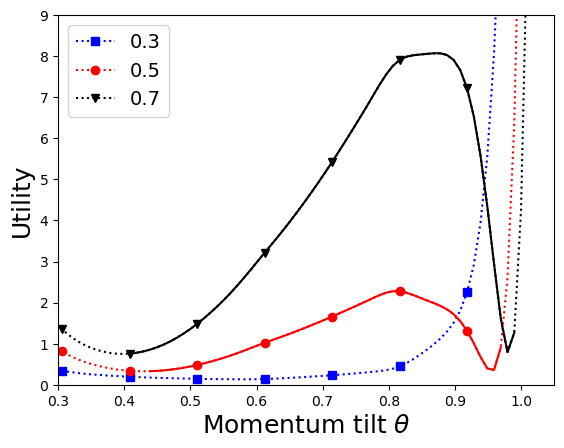

In [25]:
for idx, f in enumerate(all_utils.keys()):
    utils = Series(all_utils[f])
    deriv1 = Series(utils)-Series(utils).shift(1)
    minima = deriv1[(deriv1>0) & (deriv1.shift(1)<=0)].index.values
    utils.plot(linestyle=':', marker=markers[idx], color=colors[idx],
             markevery=10, label=f'{f}')
    if len(minima)==2:
        utils[minima[0]:minima[1]].plot(color=colors[idx])

plt.xlim((0.3, 1.05))
plt.ylim((0, 9))
plt.xlabel(r"Momentum tilt $\theta$", fontsize=fontsize)
plt.ylabel(r"Utility", fontsize=fontsize)
plt.legend(fontsize=legend_fontsize)
# fig = plt.gcf()
# fig.savefig('figs/wrds_mom_smooth_magnified.png', bbox_inches='tight')